In [1]:
#! /usr/bin/python
# -*- coding: utf-8 -*-
# @author izhangxm
# Copyright 2017 izhangxm@gmail.com. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from itertools import product
import os.path as osp
from scipy.optimize import leastsq
import time
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
class MyDataset(object):

    def __init__(self, dataset_path):

        self.dataset_path = dataset_path

        print(f"loading dataset from {self.dataset_path}....")
        df = pd.read_csv(dataset_path)
        # 数据初步处理
        # 计算反应速率rate，初始速率固定设置为0

        for c_i, (col_name, col_sr) in enumerate(df.items()):
            if "error" in col_name or "time" in col_name or "rate" in col_name:
                continue
            rate_col_name = f"{col_name}_rate"
            rates = []
            pre_t = None
            pre_v = None
            for th, (index, value) in zip(df['time'],col_sr.items()):
                if int(index) == 0:
                    rates.append(0.0)
                    pre_t = th
                    pre_v = value
                    continue

                delta_t = th-pre_t
                delta_value = value - pre_v
                # print(col_name, index, pre_t, th, pre_v ,value)
                rates.append(delta_value/delta_t)
                pre_t = th
                pre_v = value
            df[rate_col_name] = rates

        self.df = df
         # 准备输出值 Y
        self.cct_names = []
        for x in self.df.columns:
            if "time" in x or "error" in x or "rate" in x:
                continue
            self.cct_names.append(x)
        self.rates_names = [f"{x}_rate" for x in self.cct_names]
        self.error_names = [f"{x}-error" for x in self.cct_names]

        self.cct = self.df[self.cct_names].values
        self.rates = self.df[self.rates_names].values
        self.errors = self.df[self.error_names].values

        print("done!")

    def get_rates(self):
        return self.rates

    def get_df(self):
        return self.df

    def get_errors(self):
        return self.errors

    def get_cct(self):
        return self.cct

    def get_var_col_names(self):
        return self.cct_names, self.rates_names, self.error_names



In [4]:
def get_target(ks, df, k_kinetics):

    def _swt_k_kinetics(k_i, sr_vs):
        kk = k_kinetics[k_i]
        k = ks[k_i]
        if kk == 0:
            return kk
        elif kk ==1:
            return k * sr_v
        elif kk == 2:
            return k * sr_v ** 2
        raise Exception(f"unknown kinetics:{kk}")

    target = [] # 'xNH3', 'xNO3', 'xNO2', 'xNOrg', 'xN2', 'ANH3', 'ANO3', 'ANO2', 'ANOrg', 'AN2'
    for i in range(0,len(df)):
        sr = df.iloc[i]

        r1 = ks[0] * sr['xN2'] if k_kinetics[0] == 1 else ks[0]
        r2 = ks[1] * sr['xNH3'] if k_kinetics[1] == 1 else ks[1]
        r3 = ks[2] * sr['xNO2'] if k_kinetics[2] == 1 else ks[2]
        r4 = ks[3] * sr['xNO3'] if k_kinetics[3] == 1 else ks[3]
        r5 = ks[4] * sr['xNO2'] if k_kinetics[4] == 1 else ks[4]
        r6 = ks[5] * sr['xNO2'] * sr['xNO3'] if k_kinetics[5] == 1 else ks[5]
        r7 = ks[6] * sr['xNO3'] if k_kinetics[6] == 1 else ks[6]
        r8 = ks[7] * sr['xNO3'] if k_kinetics[7] == 1 else ks[7]
        r9 = ks[8] * sr['xNH3'] if k_kinetics[8] == 1 else ks[8]
        r10 = ks[9] * sr['xNOrg'] if k_kinetics[9] == 1 else ks[9]
        r11 = ks[10] * sr['xNOrg'] if k_kinetics[10] == 1 else ks[10]

        xNH3_rate =  2*r1 + r7 + r10 - r2 - r6 - r9
        xNO3_rate = r3 - r7 - r4 - r8 + r11
        xNO2_rate = r2 + r4 - r3 - r6 - 2*r5
        xNOrg_rate = r8 + r9 - r10 -r11
        xN2_rate = r5 + r6 - r1
        ANH3_rate = (2*r1*(sr['AN2'] - sr['ANH3']) + (sr['ANO3']-sr['ANH3'])*r7 + (sr['ANOrg']-sr['ANH3'])*r10 )/sr['xNH3']
        ANO3_rate = ( (sr['ANO2'] - sr['ANO3'])*r2 + (sr['ANOrg'] - sr['ANO3'])*r11 ) / sr['xNO3']
        ANO2_rate = ( (sr['ANH3']-sr['ANO2'] )*r2 + (sr['ANO3']-sr['ANO2'])*r4 ) / sr['xNO2']
        ANOrg_rate = ( (sr['ANO3']-sr['ANOrg'] )*r8 + (sr['ANH3']-sr['ANOrg'])*r9 ) / sr['xNOrg']
        AN2_rate = ( (sr['ANO2']-sr['AN2'] )*r5 + (sr['ANO2']*sr['ANH3'] - sr['AN2'])*r6 ) / sr['xN2']

        line_rate = [xNH3_rate, xNO3_rate,xNO2_rate, xNOrg_rate, xN2_rate, ANH3_rate,ANO3_rate, ANO2_rate,ANOrg_rate,AN2_rate]
        target.append(line_rate)
    target = np.array(target)
    return target


In [5]:
def r2_loss(pred, y):
    r2_loss = 1 - np.square(pred - y).sum() / np.square(y - np.mean(y)).sum()
    return r2_loss

def get_model(dataset, k_kinetics, k_sigma_priors = 0.1, kf_type=0):
    # 定义参数优化模型
    mcmc_model = pm.Model()
    ## 参数个数
    params_n = 11

    ks = []
    with mcmc_model:
        for ki in range(1, params_n+1):
            if kf_type == 0:
                p_dense = pm.HalfNormal(f"k{ki}", sigma=k_sigma_priors)
            else:
                p_dense = pm.Normal(f"k{ki}",mu=0, sigma=k_sigma_priors)
            ks.append(p_dense)

    df = dataset.get_df()
    errors = dataset.get_errors()
    rates = dataset.get_rates()


    target= get_target(ks, df, k_kinetics)
    target = np.array(target)[1:].reshape(-1).tolist()
    sigma_Y = errors[1:].reshape(-1).tolist()
    rata_Y = rates[1:].reshape(-1).tolist()

    with mcmc_model:
        sigma = pm.HalfCauchy('sigma', beta=10, initval=0.1)
        y_obs = pm.Normal(f"rates", mu=target, sigma=sigma, observed=rata_Y, shape=len(rata_Y))

    return mcmc_model


In [6]:
def get_predict_ks(idata):
    parames_summary = az.summary(idata, round_to=10)
    ks_names = [f"k{x+1}" for x in range(11)]

    predict_ks = []
    for k_name in ks_names:
        k_v = parames_summary["mean"][k_name]
        predict_ks.append(k_v)
    return np.array(predict_ks)

In [7]:
def opt_model(dataset, k_kinetics, k_sigma_priors=0.01,  kf_type=0, draws=10000, tune=2000, chains=4, cores=4):
    mcmc_model = get_model(dataset, k_kinetics, k_sigma_priors=k_sigma_priors,kf_type=kf_type)
    idata = pm.sample(draws=draws,model=mcmc_model, chains=chains, cores=cores, tune=tune)
    return idata

def eval_model(idata, dataset):
    predict_ks = get_predict_ks(idata)
    predict = get_target(predict_ks, df, k_kinetics)
    rates_y  = dataset.get_rates()
    r2 = r2_loss(predict[1:],rates_y[1:])
    return r2


In [8]:
def ltq_fit(dataset,k_kinetics):
    def _error_loss(ks, dataset):
        df = dataset.get_df()
        rates_y = dataset.get_rates()
        predict= get_target(ks, df, k_kinetics)

        r2 = r2_loss(predict[1:],rates_y[1:])
        res =  (rates_y[1:] - predict[1:]).reshape(-1)

        is_nagative = False
        for x in ks:
            if x<=0:
                is_nagative = True
                break
        # if is_nagative:
        #     res = res + 1000
        # print('step', ks,r2, res.shape)
        return res

    ks_o = np.repeat(1,11).tolist()
    ks_res =leastsq(_error_loss, ks_o, args=(dataset,))[0]
    return ks_res


loading dataset from dataset/data.csv....
done!


,time,xNH3_rate,xNO3_rate,xNO2_rate,xNOrg_rate,xN2_rate,ANH3_rate,ANO3_rate,ANO2_rate,ANOrg_rate,AN2_rate
0,0.5,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,48.0,-0.011153,0.011779,0.000381,0.000674,2.547368e-07,-0.050772,0.032181,0.000227,0.000528,0.000022
2,96.0,-0.007440,0.005084,-0.000385,-0.021708,3.500000e-07,-0.061275,0.010557,-0.000206,0.000374,0.000065
3,144.0,-0.001736,0.004588,0.000058,0.021417,4.375000e-07,-0.027376,-0.001019,0.000081,0.000273,0.000380


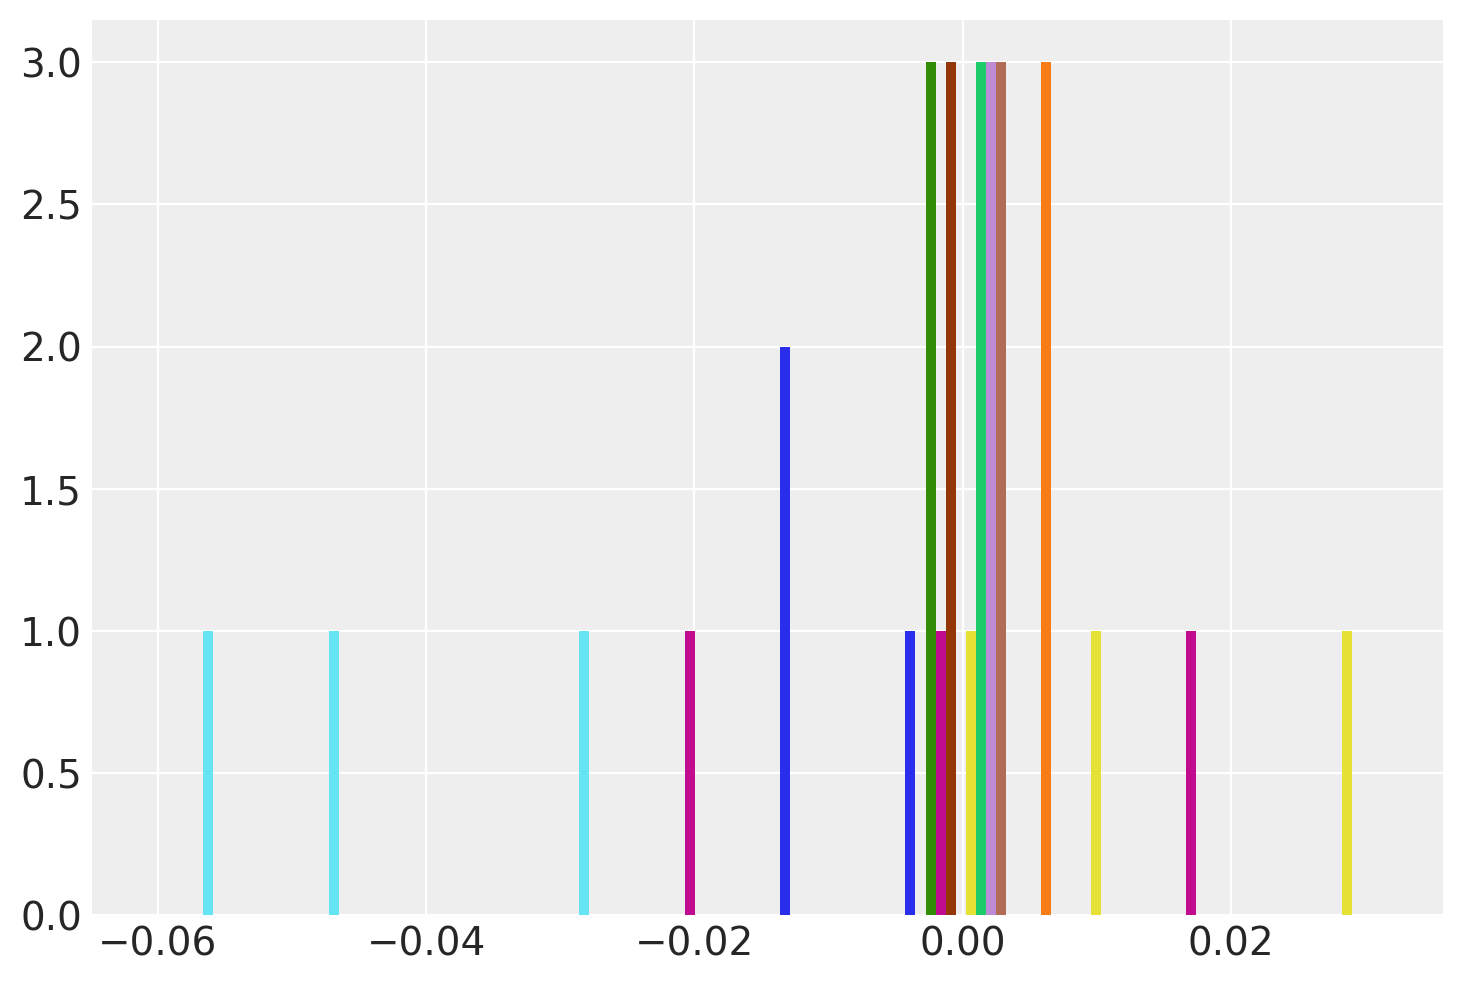

In [23]:
dataset = MyDataset("dataset/data.csv")
df = dataset.get_df()
cct_names,rates_names,error_names = dataset.get_var_col_names()

rates = dataset.get_rates()
_ = plt.hist(rates[1:])

df[['time'] +  rates_names]

In [24]:
# 全部是1级动力学，不限制K的范围
k_kinetics = np.repeat(1,11).astype(np.uint8).tolist()
idata = opt_model(dataset, k_kinetics, k_sigma_priors=0.1, kf_type=1, draws=10000, tune=2000, chains=4, cores=4)
r2 = eval_model(idata, dataset)
print(r2, k_kinetics)
# 0.7754844473588883 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] k_sigma_priors=0.1
# 0.7535096123714303 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] k_sigma_priors=0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 37 seconds.


0.7755015446026299 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
# 全部是1级动力学，限制 k>0
k_kinetics = np.repeat(1,11).astype(np.uint8).tolist()
idata = opt_model(dataset, k_kinetics, k_sigma_priors=0.01, kf_type=0, draws=10000, tune=2000, chains=4, cores=4)
r2 = eval_model(idata, dataset)
print(r2, k_kinetics)
# 0.6412686764018853 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] k_sigma_priors=0.1
# 0.6191166714084839 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] k_sigma_priors=0.01

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 26 seconds.


0.6191166714084839 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [28]:
# idata.posterior["k1"].sel(draw=slice(990, 1000))
az.summary(idata, round_to=10)
# _ = az.plot_trace(idata, combined=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k1,-2.382871e-04,0.099421,-0.186561,0.186902,4.471629e-04,5.296000e-04,49411.168032,29111.388085,0.999984
k2,3.163900e-06,0.000176,-0.000336,0.000327,9.605000e-07,8.908000e-07,33588.569267,28117.350692,1.000049
k3,2.320253e-02,0.079675,-0.123965,0.175754,3.809907e-04,3.953232e-04,43739.496054,29806.225075,1.000027
k4,-5.134000e-07,0.000043,-0.000082,0.000081,2.370000e-07,2.128000e-07,32771.879805,27241.594908,1.000106
k5,3.312190e-05,0.000865,-0.001536,0.001745,5.403600e-06,4.600300e-06,25767.048597,24346.971425,0.999993
k6,-1.897000e-06,0.000053,-0.000102,0.000097,3.269000e-07,2.789000e-07,25884.402209,24044.757112,1.000027
k7,2.247107e-04,0.000495,-0.000688,0.001185,2.604100e-06,2.291300e-06,36384.256434,27356.852293,0.999989
k8,-7.593300e-03,0.003649,-0.014491,-0.000795,2.326070e-05,1.681750e-05,24721.299855,25935.097742,1.000131
k9,2.448837e-02,0.011986,0.002189,0.047620,6.272020e-05,4.604150e-05,36677.550249,28688.205008,1.000027
k10,9.241510e-05,0.000013,0.000066,0.000117,7.320000e-08,5.190000e-08,34193.245750,28445.322695,1.000224


In [14]:
def solve_01(dataset, kk_list, save_path, k_sigma_priors=0.01):
    if osp.exists(save_path):
        f  = open(save_path, 'a')
    else:
        f  = open(save_path, 'w+')
        f.write(f"k_kinetics,k_sigma_priors, ks_res,r2\n")

    for k_kinetics in kk_list:
        idata = opt_model(dataset, k_kinetics, k_sigma_priors=k_sigma_priors, draws=10000, tune=2000, chains=4, cores=4)
        r2 = eval_model(idata, dataset)
        line_str = f'"{k_kinetics}","{k_sigma_priors}","{ks_res}","{r2}"\n'
        f.write(line_str)
        f.flush()
        print(f"k_kinetics={k_kinetics}, k_sigma_priors={k_sigma_priors}, r2={r2}")
    f.close()


In [17]:
def solve_02(dataset, kk_list, save_path):

    if osp.exists(save_path):
        f  = open(save_path, 'a')
    else:
        f  = open(save_path, 'w+')
        f.write(f"k_kinetics,ks_res,r2\n")

    for k_kinetics in kk_list:
        ks_res = ltq_fit(dataset,k_kinetics )
        predict= get_target(ks_res, dataset.get_df(), k_kinetics)
        rates_y = dataset.get_rates()
        r2 = r2_loss(predict[1:],rates_y[1:])
        line_str = f'"{k_kinetics}","{ks_res}","{r2}"\n'
        f.write(line_str)
        f.flush()
        print(f"k_kinetics={list(k_kinetics)}, r2={r2}")
    f.close()



In [21]:
kk_list_all = list(product([0,1], repeat=11))
kk_list = np.vstack([np.repeat(0,11).astype(np.uint8), np.eye(11,11, dtype=np.uint8), np.repeat(1,11).astype(np.uint8)]).tolist()
dataset = MyDataset("dataset/data.csv")

solve_02(dataset,kk_list,save_path="lsq_temp.csv" )


loading dataset from dataset/data.csv....
done!
k_kinetics=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], r2=0.8124185944967925
k_kinetics=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], r2=0.8132599345385618
k_kinetics=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], r2=0.8124188475175166
k_kinetics=[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], r2=0.8125377132530056
k_kinetics=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], r2=0.8124180715538909
k_kinetics=[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], r2=0.8124229761423063
k_kinetics=[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], r2=0.8124170382487262
k_kinetics=[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], r2=0.8134512961052908
k_kinetics=[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], r2=0.7983958940970844
k_kinetics=[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], r2=0.793370355698932
k_kinetics=[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], r2=0.8108134886555125
k_kinetics=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], r2=0.8142171969928428
k_kinetics=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], r2=0.7767488693235725
